__Conduct a brief exploratory analysis on a 18500 point random sample of sediment thicknesses from NOAA's Crustal Sediment Thickness dataset. Further, explore the spatial structure of the data using cluster analysis.__

In [2]:
### Load the data into a pandas dataframe:

fpath='/Users/paulp/GoogleDrive/projects/ContinentalMarginMapping/data/'
hdr=['easting','northing', 'id','thickness','depth', 'X','Y']

df = pd.read_csv(fpath+'SedThkness_region03_18500randpts_xyz.csv', header=0, names=hdr)

# drop the first x, and y fields (they're redundant):
del df['X']
del df['Y']

<h3>Some Basic Statistics:</h3>

In [3]:
### quick and simple statistics:

#df.head()
df.describe()

,easting,northing,id,thickness,depth
count,1.850000e+04,1.850000e+04,18500.000000,18500.000000,18500.000000
mean,-1.086693e+07,2.814588e+06,9250.500000,1738.411782,-3522.316531
std,2.483999e+06,7.437839e+05,5340.634326,2901.823687,1744.307914
min,-1.486150e+07,1.668500e+06,1.000000,10.861584,-8384.296000
25%,-1.333050e+07,2.199250e+06,4625.750000,100.966271,-4788.435250
50%,-1.051950e+07,2.729500e+06,9250.500000,429.657440,-4072.972500
75%,-8.488500e+06,3.339500e+06,13875.250000,1822.712829,-2640.011750
max,-6.847500e+06,4.502500e+06,18500.000000,16676.121094,-0.000017


<h3>Exploratory Plots:</h3>

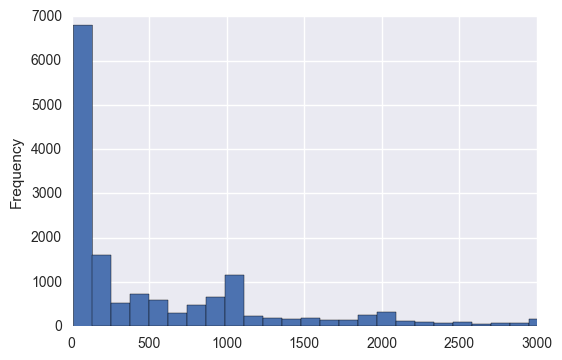

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline
### exploratory 2-D plots:

#boxes=df.boxplot(column='t', return_type='axes')
#sp = df.plot(kind='scatter', x='easting', y='thickness', s=5, c='blue', edgecolors='blue')
h = df['thickness'].plot(kind='hist', bins=136, xlim=[0,3000])   ## bins=square root n where n = 18500
#kdp = df['thickness'].plot(kind='kde', xlim=([0, 30000]) )



<IPython.core.display.Javascript object>


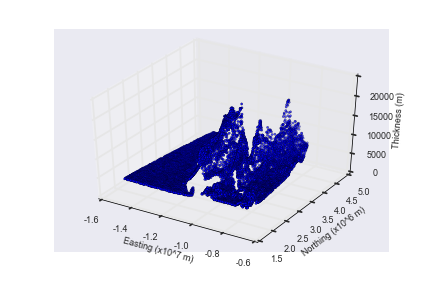

In [33]:
## exploratory 3-D plots:


#plt.switch_backend('nbagg')
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

ax3d=plt.axes(projection='3d')
ax3d.scatter3D(df.easting, df.northing, df.thickness, s=5, cmap='Greens')

ax3d.set_xticklabels([-1.6,-1.4,-1.2,-1.0,-0.8,-0.6], fontsize=9)
ax3d.set_yticklabels([1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0], fontsize=9)
ax3d.set_zticklabels([0,5000,10000,15000,20000], fontsize=9)

ax3d.set_xlabel('Easting (x10^7 m)', fontsize=9)
ax3d.set_ylabel('Northing (x10^6 m)', fontsize=9)
ax3d.set_zlabel('Thickness (m)', fontsize=9)

plt.show()

<h3>Clustering Experiments: k-means</h3>

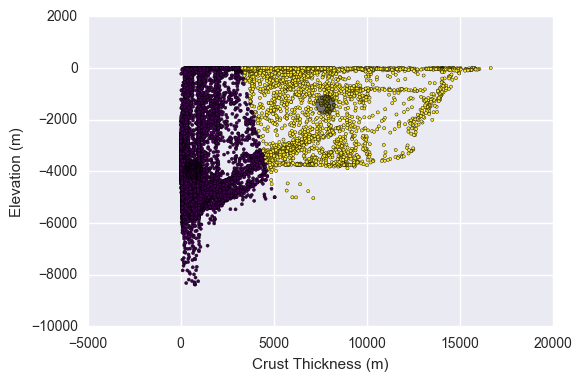

In [34]:
from sklearn.cluster import KMeans

%matplotlib inline

X = np.array([df.thickness, df.depth]).T

#plt.scatter(X[:,0], X[:,1], s=5)

kmeans = KMeans(n_clusters=2).fit(X)
y_means = kmeans.predict(X)
centers = kmeans.cluster_centers_

plt.scatter(X[:,0], X[:,1], c=y_means, s=5, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

plt.xlabel('Crust Thickness (m)')
plt.ylabel('Elevation (m)')

<h3>Clustering Experiments: Fisher-Jenks Natural Breaks:</h3>

In [12]:
### compute 1-D natural breaks using the Natural Breaks module in PySAL

from pysal.esda.mapclassify import Natural_Breaks as nb


## FUNCTIONS:
def ComputeNaturalBreaks(pc_array, klasses):
    '''
    partitions data into classes using PySAL pysal.esda.mapclassify, Natural_Breaks algorithm. 
    input: array of values to classify
    returns: upper bounds for classes
    '''
    breaks=nb(pc_array, k=klasses, initial=20)
    return(breaks)



def goodness_of_variance_fit(array, classes):
    # get the break points
    #classes = jenks(array, classes)

    # do the actual classification - assign values based on class breaks
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf


def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

### END FUNCTIONS

X = np.array(df.thickness)
#X = np.array(df.depth)

klasses=2
gvf = 0.0
gvf_acceptance=0.80
    
# compute F-J natural breaks and goodness of fit:
while(gvf < gvf_acceptance):
    print('Trying', klasses, 'class breaks...')
    # classify data using PySAL Natural Breaks Lib.
    breaks=ComputeNaturalBreaks(X, klasses)

    # compute goodness of variance fit
    gvf = goodness_of_variance_fit(X, breaks.bins)   #(data, nclasses)
    klasses+=1
    
#print results:
print()
print('Number of class breaks:', klasses-1)
print('Bins:', breaks.bins)  


Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...

Number of class breaks: 4
Bins: [   737.345154   2863.395996   7017.302246  16676.121094]


/Users/paulp/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


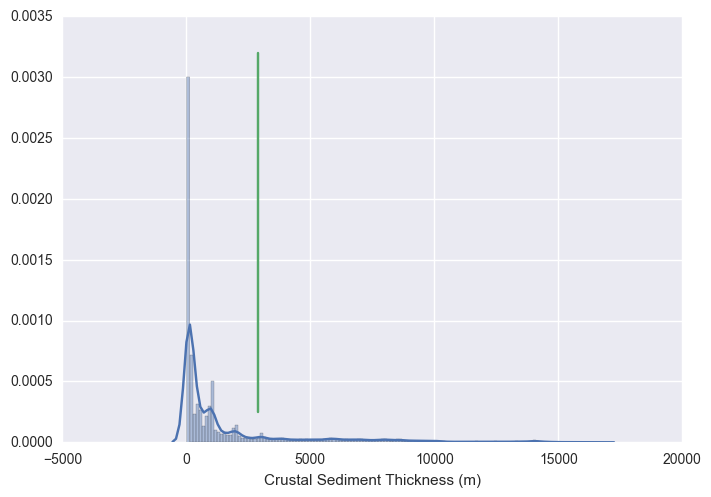

In [13]:
#h = df['thickness'].plot(kind='hist', bins=136, xlim=[0,3000])   ## bins=square root n where n = 18500
#kdp = df['thickness'].plot(kind='kde', xlim=([0, 3000]) )

sns.distplot(df.thickness, kde=True, rug=False, bins=136)
#plt.plot((745,745),(.00045,.0032))
plt.plot((2897,2897), (.00025,.0032))

plt.xlabel('Crustal Sediment Thickness (m)')

Based on findings:

Number of class breaks (from Fisher-Jenks Natural Breaks): 4
Bins: [   745   __2897__   7067  16676] all in meters<br>

What about a limiting maximum depth? 

Number of class breaks (from Fisher-Jenks Natural Breaks): 4
Depth Bins: [ -4,481  __-3,015__  -1,220  0]


So, starting bounds will be as follows:

- bottom slope to define the flat or planar surface: 0.69°  (from Wright et al., 2001 and Paris, Walsh, and Corbett, 2016)
- limiting depth down to 3,015 meters
- limiting sediment thickness, >= 2,897 meters
- geomorphon type(s): slope, ???